# Create grid
- Get boundary of the city in from OSM
- Find the administrative output areas within that boundary
- Create a grid based on those

In [5]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import shapely.wkb
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# User settings
place_name = "Grand Paris Metropolis"
crs_fr = 2154 
#crs_fr = 4326

plt.rcParams['figure.figsize'] = (8, 8)

## Find administrative output area within boundary
- get boundary
- get shapes of the administrative output areas
- subset the areas for those within the boundary

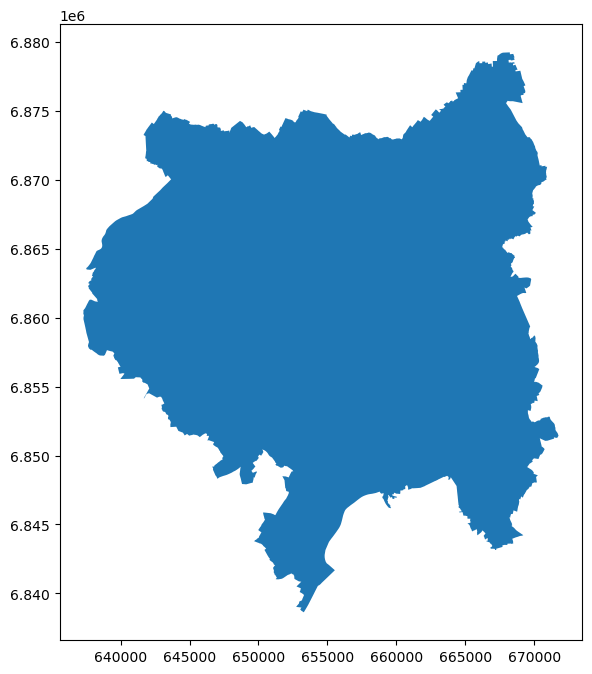

In [2]:
### Get boundary from OSM
GPM = ox.geocode_to_gdf(place_name)
GPM = GPM.to_crs(crs_fr)
GPM.plot()
GPM.to_file('data/raw/GPM_geometry/GPM.geojson', driver = 'GeoJSON')

In [4]:
GPM

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((637298.022 6860280.848, 637298.584 6...",49.012332,48.646162,2.615768,2.145707,308326646,relation,5814660,48.829224,2.366974,"Grand Paris Metropolis, Val-de-Marne, Ile-de-F...",boundary,local_authority,0.755627


In [3]:
### Get all IRIS shapes in France
IRIS_fr = gpd.read_file("data/raw/IRIS_shapes/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2022-06-00180/CONTOURS-IRIS_2-1_SHP_LAMB93_FXX-2022/CONTOURS-IRIS.shp")
IRIS_fr = IRIS_fr.to_crs(crs_fr)
IRIS_fr.plot()

DriverError: data/raw/IRIS_shapes/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2022-06-00180/CONTOURS-IRIS_2-1_SHP_LAMB93_FXX-2022/CONTOURS-IRIS.shp: No such file or directory

<AxesSubplot: >

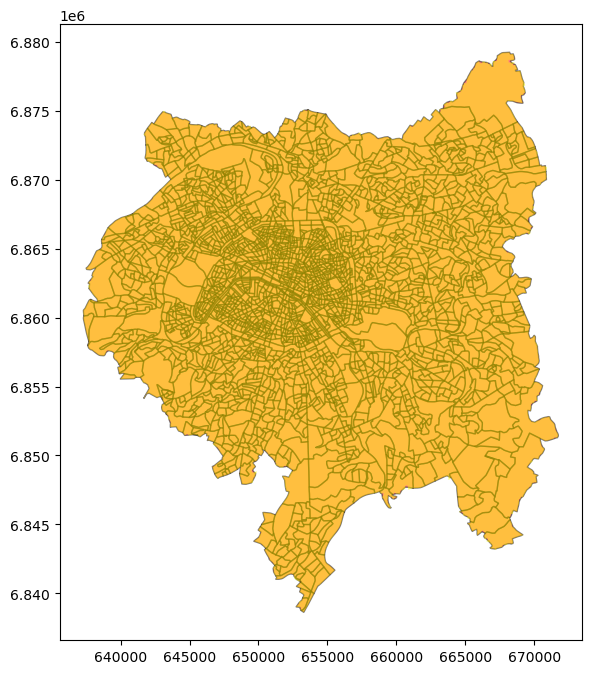

In [4]:
### Find IRIS within GPM

# Find centroids and define them as the geometry
IRIS_fr['representative_point'] = IRIS_fr.representative_point()
IRIS_fr = IRIS_fr.set_geometry('representative_point')

# Find polygons whose representative points fall within GPM
IRIS_GPM = gpd.sjoin(IRIS_fr, GPM, how= 'inner')
IRIS_GPM = IRIS_GPM.set_geometry('geometry').drop(columns = 'representative_point')

ax = plt.axes()
IRIS_GPM.plot(ax=ax, alpha = 0.5, facecolor = 'red', edgecolor ='black')
GPM.plot(ax=ax, alpha = 0.5, facecolor = 'yellow')

In [5]:
### Save as geojson
IRIS_GPM.to_file('data/processed/GPM_IRIS.geojson', driver = 'GeoJSON')

## Create grid 
- find smallest administrative output area
- Create a grid with that cell size 
- Add centroids

In [7]:
### Get the GPM IRIS
IRIS_GPM = gpd.read_file('data/processed/GPM_IRIS.geojson').drop(columns = ['index_right',  
                                                                            'osm_type', 
                                                                            'type', 
                                                                            'bbox_west', 
                                                                            'bbox_south', 
                                                                            'bbox_east', 
                                                                            'bbox_north', 
                                                                            'TYP_IRIS', 
                                                                            'display_name',
                                                                            'IRIS',
                                                                            'INSEE_COM',
                                                                            'place_id',
                                                                            'class',
                                                                            'importance',
                                                                            'osm_id',
                                                                            'lat',
                                                                            'lon'])
IRIS_GPM.head(2)

,NOM_COM,CODE_IRIS,NOM_IRIS,geometry
0,Paris 11e Arrondissement,751114113,Folie Méricourt 13,"POLYGON ((654130.100 6863650.800, 654171.300 6..."
1,Levallois-Perret,920440109,Wilson-Rivay 1,"POLYGON ((648086.800 6866229.600, 648055.600 6..."


In [9]:
### Find smallest administrative output area (surface-wise)

IRIS_GPM['area'] = IRIS_GPM.area
IRIS_GPM = IRIS_GPM.sort_values(by='area').reset_index(drop = True)
smallest_IRIS_GPM = IRIS_GPM.head(1)
smallest_IRIS_GPM

,NOM_COM,CODE_IRIS,NOM_IRIS,geometry,area
0,Paris 4e Arrondissement,751041305,Saint-Merri 5,"POLYGON ((652530.100 6862186.900, 652619.400 6...",8739.53


In [10]:
### Create grid with cell size = smallest output area 

# bounds of the smallest IRIS 
XMIN, YMIN, XMAX, YMAX = smallest_IRIS_GPM.total_bounds

# bounds of the whole grid
xmin, ymin, xmax, ymax= IRIS_GPM.total_bounds

# cell size in x and y direction 
cell_size_x = int((xmax-xmin)/(XMAX-XMIN))
cell_size_y = int((ymax-ymin)/(YMAX-YMIN))

# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size_x, cell_size_x ):
    for y0 in np.arange(ymin, ymax+cell_size_y, cell_size_y):
        # bounds
        x1 = x0-cell_size_x
        y1 = y0+cell_size_y
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))  

# create complete grid and add centroids
grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs_fr)
grid['centroid'] = grid.centroid 

<AxesSubplot: >

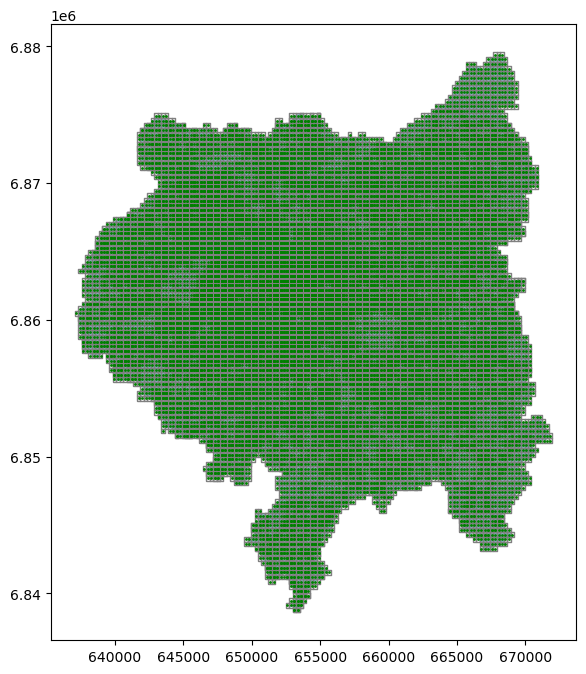

In [11]:
#only keep grid within boundary
grid_GPM = gpd.sjoin(grid, IRIS_GPM, how= 'inner')

# plot for verification
ax = plt.axes()
IRIS_GPM.plot(ax=ax, alpha = 0.5)
grid_GPM.plot(ax=ax, facecolor="none", edgecolor='grey')
grid_GPM['centroid'].plot(ax=ax, markersize=1, facecolor = 'green')

In [16]:
### Save as csv to allow for both the grid and the centroids (= geometries) to be saved 

# Reproject stuff
grid_GPM_reproject = grid_GPM.to_crs(4326).drop(columns = ['centroid','area', 'index_right']) #for the polygons
grid_GPM_reproject['centroid'] = grid_GPM_reproject.centroid #recalculate centroids
grid_GPM_reproject #
grid_centroids_IRIS_GPM = pd.DataFrame(grid_GPM_reproject)
grid_centroids_IRIS_GPM.to_csv('data/processed/GPM_grid.csv', index = False)

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_20934/3517152703.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_GPM_reproject['centroid'] = grid_GPM_reproject.centroid #recalculate centroids


In [11]:
# ### code snippet on how to use the csv later on

# grid_centroids = pd.read_csv('data/processed/GPM_grid.csv')

# for c in ['geometry', 'centroid']:
#     test[c] = test[c].apply(shapely.wkt.loads)

# grid_centroids = gpd.GeoDataFrame(grid_centroids, crs = crs_fr, geometry= 'geometry' )

# ax = plt.axes()

# grid_centroids.plot(ax=ax, facecolor="none", edgecolor='grey', linewidth = 0.1)
# grid_centroids.centroid.plot(ax=ax, markersize=1, facecolor = 'green')

In [12]:
# ### Connecting stuff


# """
# H = car network (networkX graph, nodes and edges)
# banw = bike network (networkX graph, nodes and edges)
# grid_centroids = grid with centroids (GeoDataFrame, geometries for cells and for centroids)

# thoughts:
# - turn the centroids into a completely disconnected network of nodes DONE
# - make the nodes have the necessary info to connect them back to IRIS (but not more!) DONE? 
# - then see how to connect them to their closest neighbor in banw or H (R5R?)
# """

# # only use centroids
# centroid_nodes = grid_centroids[['centroid', 'CODE_IRIS']].set_geometry('centroid')

# # separate coordinates for x and y 
# centroid_nodes['x'] = centroid_nodes['centroid'].x
# centroid_nodes['y'] = centroid_nodes['centroid'].y

# # Create a dictionary of attributes 
# centroid_nodes["attr_dict"] = centroid_nodes.apply(lambda k: make_attr_dict(x = k.x, y = k.y, code_iris = k.CODE_IRIS), axis = 1) # add attr_dict
# centroid_nodes['num'] = centroid_nodes.index

# # Turn the centroids into nodes of a graph
# grid = nx.Graph()
# grid.add_nodes_from(centroid_nodes.loc[:,["num", "attr_dict"]].itertuples(index = False))